In [2]:
import pandas as pd

df = pd.read_csv("tomato irrigation dataset.csv")
print(df.head())
print(df.info())
print(df.describe())
print(df.duplicated().sum()) #This line of code counts the number of duplicated rows 
print(df.dtypes) #This line of code is used to display the data types of each column

print(df.isnull().sum()) #This line checks how many missing (null) values exist in each column  

   Temperature [_ C]   Humidity [%]  Soil moisture  \
0                31.2          93.6          567.0   
1                31.2          93.6          567.0   
2                30.5          74.6          307.0   
3                30.4          76.6          308.0   
4                30.4          76.6          308.0   

   Reference evapotranspiration  Evapotranspiration  Crop Coefficient  \
0                    563.000086          236.460036              0.42   
1                    561.176578          235.694163              0.42   
2                    561.267170          235.732211              0.42   
3                    559.447778          234.968067              0.42   
4                    559.447778          234.968067              0.42   

  Crop Coefficient stage  Nitrogen [mg/kg]  Phosphorus [mg/kg]  Potassium  \
0          Initial Stage               107                  38         53   
1          Initial Stage               107                  38         53   
2    

# Cleaning of data

In [11]:
import pandas as pd

df = pd.read_csv("tomato irrigation dataset.csv")

# Remove duplicates
df = df.drop_duplicates()

# Remove pH outliers
df = df[(df['pH'] >= 3.5) & (df['pH'] <= 9.0)]

# Drop or encode 'Crop Coefficient stage'
df['Crop Coefficient stage'] = df['Crop Coefficient stage'].astype('category').cat.codes

# (Optional) Scale the features
from sklearn.preprocessing import StandardScaler
X = df.drop(columns=['Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 'Potassium'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# MODEL

In [14]:
def classify_npk(value, thresholds):
    if value < thresholds[0]:
        return 0  # Low
    elif value < thresholds[1]:
        return 1  # Medium
    else:
        return 2  # High

# Example thresholds (mg/kg) — adjust based on agronomy standards
df['N_label'] = df['Nitrogen [mg/kg]'].apply(lambda x: classify_npk(x, [80, 100]))
df['P_label'] = df['Phosphorus [mg/kg]'].apply(lambda x: classify_npk(x, [80, 100]))
df['K_label'] = df['Potassium'].apply(lambda x: classify_npk(x, [80, 100]))

X = df.drop(columns=['Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 'Potassium',
                     'N_label', 'P_label', 'K_label'])  # Features
y = df[['N_label', 'P_label', 'K_label']]  # Multi-output classification labels

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print("Nitrogen:\n", classification_report(y_test['N_label'], y_pred[:,0]))
print("Phosphorus:\n", classification_report(y_test['P_label'], y_pred[:,1]))
print("Potassium:\n", classification_report(y_test['K_label'], y_pred[:,2]))

Nitrogen:
               precision    recall  f1-score   support

           0       0.29      0.31      0.30       118
           1       0.32      0.33      0.32       128
           2       0.48      0.45      0.46       180

    accuracy                           0.37       426
   macro avg       0.36      0.36      0.36       426
weighted avg       0.38      0.37      0.38       426

Phosphorus:
               precision    recall  f1-score   support

           0       0.63      0.92      0.75       266
           1       0.28      0.08      0.12       112
           2       0.00      0.00      0.00        48

    accuracy                           0.60       426
   macro avg       0.30      0.34      0.29       426
weighted avg       0.46      0.60      0.50       426

Potassium:
               precision    recall  f1-score   support

           0       0.54      0.62      0.58       201
           1       0.00      0.00      0.00        70
           2       0.44      0.54      

In [18]:
print(y_train['N_label'].value_counts())
print(y_train['P_label'].value_counts())
print(y_train['K_label'].value_counts())


N_label
2    673
0    524
1    503
Name: count, dtype: int64
P_label
0    1019
1     460
2     221
Name: count, dtype: int64
K_label
0    782
2    616
1    302
Name: count, dtype: int64


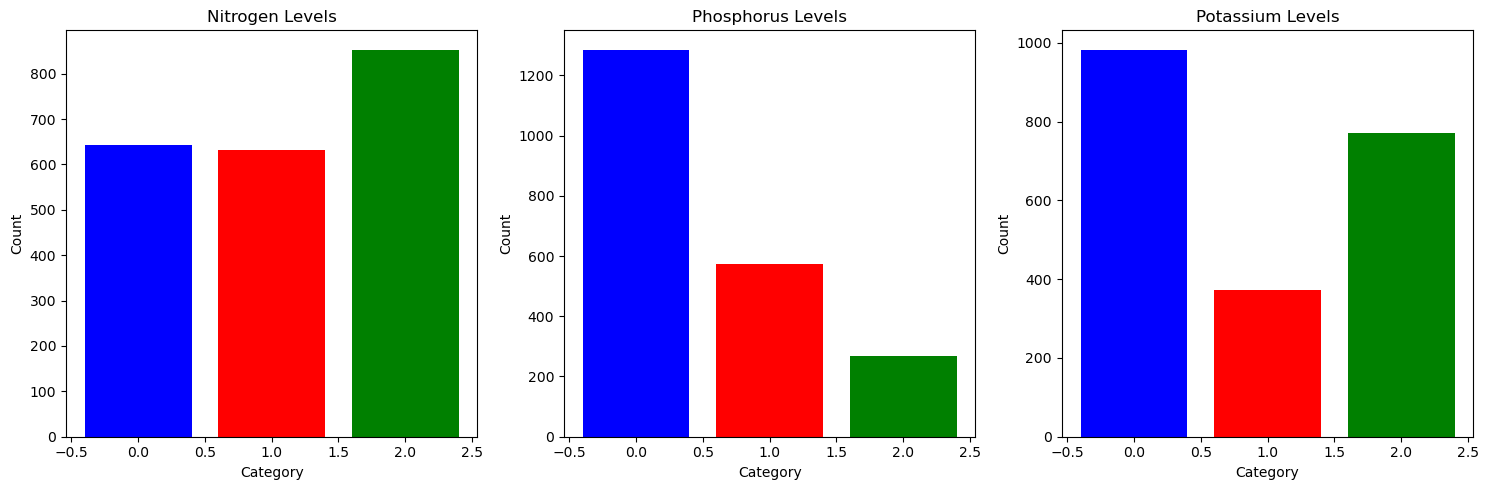

   N_label  P_label  K_label
0      642     1285      983
1      631      572      372
2      853      269      771


In [20]:
import matplotlib.pyplot as plt

# Set up the plot style
#plt.style.use('seaborn-v0_8-colorblind')  # nicer colors

# Create subplots for each nutrient label
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Nutrients to visualize
nutrients = ['N_label', 'P_label', 'K_label']
titles = ['Nitrogen Levels', 'Phosphorus Levels', 'Potassium Levels']

for i, nutrient in enumerate(nutrients):
    counts = df[nutrient].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, color=['blue', 'red', 'green'])
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Category')
    
plt.tight_layout()
plt.show()
print(df[['N_label', 'P_label', 'K_label']].apply(lambda col: col.value_counts()))

# Model 2(using SMOTE)

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

#  Defining label thresholds for nutrients
def classify_npk(value, thresholds):
    low, high = thresholds
    if value < low:
        return 0  # Low
    elif value <= high:
        return 1  # Optimal
    else:
        return 2  # High

#  Applying labels
df['N_label'] = df['Nitrogen [mg/kg]'].apply(lambda x: classify_npk(x, [80, 100]))
df['P_label'] = df['Phosphorus [mg/kg]'].apply(lambda x: classify_npk(x, [60, 90]))
df['K_label'] = df['Potassium'].apply(lambda x: classify_npk(x, [60, 100]))

# Choosing one nutrient to predict (repeat for others!)
target = 'N_label'  
target = 'P_label'
target = 'K_label'
features = df[['pH', 'Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 'Potassium']]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Applying SMOTE for class balance(otherwise very low predictiility)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Train classifier
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_bal, y_train_bal)

# Evaluating w confusion matrix
y_pred = model.predict(X_test_scaled)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[122   0   0]
 [  0 153   0]
 [  0   0 151]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       153
           2       1.00      1.00      1.00       151

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



In [25]:
print(X_train.shape, X_test.shape)

(1700, 4) (426, 4)


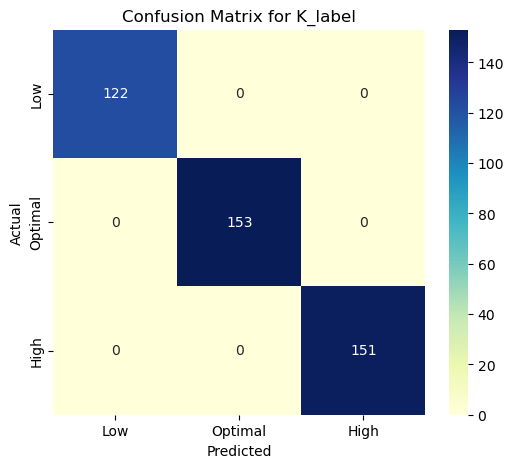

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict using our trained model
y_pred = model.predict(X_test_scaled)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Low', 'Optimal', 'High']

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {target}')
plt.show()

# Recommendtion System

In [25]:
def recommend_fertilizer(n, p, k):
    recommendations = []

    # Nitrogen
    if n == 0:
        recommendations.append("Apply nitrogen fertilizer: Urea at 100–120 kg/ha.")
    elif n == 1:
        recommendations.append("Nitrogen level is optimal. No action needed.")
    else:
        recommendations.append("Nitrogen level is high. Consider avoiding further nitrogen application.")

    # Phosphorus
    if p == 0:
        recommendations.append("Apply phosphorus fertilizer: Single Super Phosphate at 80–100 kg/ha.")
    elif p == 1:
        recommendations.append("Phosphorus level is sufficient.")
    else:
        recommendations.append("Phosphorus level is high. Avoid additional phosphorus to prevent micronutrient lockout.")

    # Potassium
    if k == 0:
        recommendations.append("Apply potassium fertilizer: Muriate of Potash at 60–80 kg/ha.")
    elif k == 1:
        recommendations.append("Potassium level is within range.")
    else:
        recommendations.append("Potassium level is excessive. Skip potash fertilizers to maintain nutrient balance.")

    return recommendations

In [27]:
#example:
recommend_fertilizer(n=0, p=1, k=2)

['Apply nitrogen fertilizer: Urea at 100–120 kg/ha.',
 'Phosphorus level is sufficient.',
 'Potassium level is excessive. Skip potash fertilizers to maintain nutrient balance.']